Sketching outline of "lite" lensing likelihood wrapper for Cobaya

In [1]:
import numpy as np
from scipy.stats import multivariate_normal

lmax = 2000

data, noise = np.loadtxt('fake_data.txt', unpack=True)
noise = np.absolute(noise)
ell = np.arange(lmax + 1)
cov = np.identity(lmax + 1) * noise 
# for l in range(lmax - 1):
#     cov[l, l + 1] = np.random.randn() * 1e-12
cov += np.random.standard_normal(cov.shape) * 1e-11
cov = np.absolute(cov)
cov = np.dot(cov, cov.transpose())

class LensingLiteLikelihood(object):
    def __init__(self, data, cov):
        self.data = data
        self.cov = cov
        
    def __call__(self, _theory={'Cl': {'tt': lmax, 'pp': lmax}}):
        cl = _theory.get_Cl(ell_factor=True)
        theory_pp = cl['pp']
        return multivariate_normal.logpdf(self.data, mean=theory_pp, cov=self.cov)        
    
lensing_lite_loglike = LensingLiteLikelihood(data, cov)

In [2]:
cov

array([[2.05761381e-19, 1.28504594e-19, 1.36883567e-19, ...,
        1.28374487e-19, 1.27612598e-19, 1.26725116e-19],
       [1.28504594e-19, 1.96736706e-19, 1.45370237e-19, ...,
        1.24667514e-19, 1.24044481e-19, 1.21898747e-19],
       [1.36883567e-19, 1.45370237e-19, 3.30278226e-17, ...,
        1.68904501e-19, 1.50489288e-19, 2.22529087e-19],
       ...,
       [1.28374487e-19, 1.24667514e-19, 1.68904501e-19, ...,
        2.12034237e-19, 1.25132628e-19, 1.24382348e-19],
       [1.27612598e-19, 1.24044481e-19, 1.50489288e-19, ...,
        1.25132628e-19, 2.03552323e-19, 1.25238969e-19],
       [1.26725116e-19, 1.21898747e-19, 2.22529087e-19, ...,
        1.24382348e-19, 1.25238969e-19, 2.04771677e-19]])

In [3]:
from collections import OrderedDict

info = {'likelihood': {'lensing_lite': lensing_lite_loglike},
        
         'params': {#'logA': 3.05,
#                     'n_s': 0.965,
# #                     'theta_s_1e2': 1.0416,
#                     'omega_b': 0.0224,
#                     'omega_cdm': 0.12,
#                     'tau_reio': 0.055,
                   },
         'sampler': {'mcmc': {'covmat': 'auto', 'drag': True, 'proposal_scale': 1.9}},
         'theory': {'classy': 
                       {'extra_args': 
                           {'non linear': 'halofit',
                            'N_ncdm': 1,
                            'N_ur': 2.0328}}
                   }
       }
        
#         OrderedDict([('classy',
#                                  OrderedDict([('extra_args',
#                                                OrderedDict([('non linear', 'halofit'),
#                                                             ('N_ncdm', 1),
#                                                             ('N_ur', 2.0328)]))]))])}

In [4]:
from cobaya.model import get_model
model = get_model(info)

[model] *WARNING* Ignored blocks/options: ['sampler']
[prior] *WARNING* No sampled parameters requested! This will fail for non-mock samplers.
[lensing_lite] Initialised external likelihood.
[classy] Importing *global* CLASS.
[likelihood] The theory code will compute the following products, requested by the likelihoods: ['Cl']


In [5]:
model.loglike({}, cached=False)

[lensing_lite] *ERROR* ----------------

Traceback (most recent call last):
  File "/Users/tmorton/miniconda3/envs/cobaya/lib/python3.7/site-packages/cobaya/likelihood.py", line 127, in _logp_cached
    raise StopIteration
StopIteration

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/tmorton/miniconda3/envs/cobaya/lib/python3.7/site-packages/cobaya/likelihood.py", line 250, in logp
    return self.external_function(**params_values)
  File "<ipython-input-1-ba60951a77cb>", line 24, in __call__
    return multivariate_normal.logpdf(self.data, mean=theory_pp, cov=self.cov)
  File "/Users/tmorton/miniconda3/envs/cobaya/lib/python3.7/site-packages/scipy/stats/_multivariate.py", line 495, in logpdf
    psd = _PSD(cov, allow_singular=allow_singular)
  File "/Users/tmorton/miniconda3/envs/cobaya/lib/python3.7/site-packages/scipy/stats/_multivariate.py", line 163, in __init__
    raise np.linalg.LinAlgError('singular matrix

(-inf, [])

In [185]:
model.loglike({}, cached=False)

(14594.77284991124, [])

(Used the following to generate the above data)

In [85]:
cl = model.likelihood.theory.get_Cl(ell_factor=True)
cl

{'tt': array([   0.        ,    0.        , 1084.35237716, ...,  242.67671493,
         242.68888506,  242.70000654]),
 'pp': array([0.00000000e+00, 0.00000000e+00, 5.10929891e-08, ...,
        1.43821414e-09, 1.43623032e-09, 1.43424925e-09]),
 'tp': array([0.00000000e+00, 0.00000000e+00, 3.53828161e+03, ...,
        8.79507736e-04, 8.79216129e-04, 8.78868418e-04]),
 'ell': array([   0,    1,    2, ..., 1998, 1999, 2000])}

In [103]:
noise = cl['pp'] * np.random.standard_normal(cl['pp'].shape) * 0.1
fake_data = cl['pp'] + noise
np.savetxt('fake_data.txt', np.array([fake_data, noise]).T)

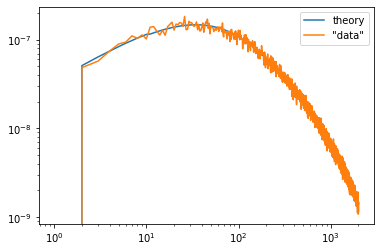

In [100]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.loglog(cl['ell'], cl['pp'], label='theory')
plt.loglog(cl['ell'], fake_data, label='"data"')
plt.legend()